<a href="https://colab.research.google.com/github/sokrypton/seqsal/blob/master/seqsal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# ------------------------------------------------------------
# "THE BEERWARE LICENSE" (Revision 42):
# ------------------------------------------------------------
# <dylan_marshall@fas.harvard.com>, <so@g.harvard.edu> and 
# <koo@cshl.edu> wrote this code. As long as you retain this
# notice, you can do whatever you want with this stuff. If we 
# meet someday, and you think this stuff is worth it, you can
# buy us a beer in return.
# -Dylan Marshall, Sergey Ovchinnikov and Peter Koo
# ------------------------------------------------------------

#Load Libraries

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow.compat.v1.keras.backend as K1
import tensorflow.keras.backend as K

tf1.disable_eager_execution()

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Activation, Dropout, BatchNormalization, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import Zeros, Constant

TensorFlow 2.x selected.


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform

#MODELS
**WARNING**: the default settings for each model are NOT optimal. The purpose of this notebook is just to demonstrate the utlility of a pairwise saliency analysis. We are not making any claims about which model is "better".

In [0]:
def train_model(model, X, W, schedule, verbose=False):
  N = X.shape[0]
  idx = np.arange(N)
  for batch_size, epochs in schedule:
    if batch_size == N:
      model.fit(X, X, sample_weight=W,
                batch_size=batch_size,verbose=verbose, epochs=epochs)
    else:
      for e in range(epochs):
        np.random.shuffle(idx)
        model.fit(X[idx], X[idx], sample_weight=W[idx],
                  batch_size=batch_size, verbose=verbose, epochs=1)

###MRF

In [0]:
def mrf(X, W, use_bias=False, lam=0.01, train=True):
  '''
  Markov Random Field with pseudolikelihood approximation
  aka GREMLIN
  '''
  N,L,A = X.shape
  F = L*A
  
  # clear graph
  tf1.reset_default_graph()
  K.clear_session()
    
  #####################################################
  # setup kernel
  #####################################################
  def cst_w(weights):
    weights = (weights + K.transpose(weights)) / 2
    mask = K.constant((1-np.eye(L))[:,None,:,None], dtype=tf.float32)
    weights = K.reshape(weights, (L,A,L,A)) * mask
    return K.reshape(weights,(F,F))
  
  params = {"units":F,
            "kernel_initializer":Zeros,
            "kernel_regularizer":l2((lam/N)*(L-1)*(A-1)/2),
            "kernel_constraint":cst_w}
  
  #####################################################
  # setup bias
  #####################################################
  if use_bias:
    init_v = np.log((X.T*W).sum(-1).T + lam*np.log(W.sum()))
    params["bias_initializer"] = Constant(init_v - init_v.mean(-1, keepdims=True))
    params["bias_regularizer"] = l2(lam/N)
  else:
    params["use_bias"] = False
   
  #####################################################
  # setup model
  #####################################################
  model = Sequential()
  model.add(Flatten(input_shape=(L,A)))
  model.add(Dense(**params))
  model.add(Reshape((L, A)))
  model.add(Activation("softmax"))
  
  #####################################################
  # compile and train
  #####################################################
  if train:
    def loss(p, q):
      return K.sum(K.categorical_crossentropy(p,q),-1)
    model.compile(Adam(0.1*np.log(W.sum())/L), loss)
    train_model(model,X,W,[[N,200]])
  
  return model

###LAE

In [0]:
# Linear Auto-Encoder
def lae(X, W, 
        enc=[], rank=256, dec=[],
        lam_w=0.1, lam_e=1.0, use_e=True,
        use_bias=False, train=True):
  
  N,L,A = X.shape
  F = L*A

  # clear graph
  tf1.reset_default_graph()
  K.clear_session()
    
  # model params
  params_w = {"use_bias":use_bias, "kernel_regularizer":l2(lam_w * F/N)}
  params_e = {"use_bias":use_bias, "kernel_regularizer":l2(lam_e)}
  
  #####################################################
  # encoder
  #####################################################
  model = Sequential()
  model.add(Flatten(input_shape=(L,A)))
  for unit in enc: model.add(Dense(uni, **params_w))
  model.add(Dense(rank, **params_w))
  
  #####################################################
  # decoder
  #####################################################
  for unit in dec: model.add(Dense(uni, **params_w))
  model.add(Dense(F, **params_w))
  model.add(Reshape((L,A)))
  if use_e: model.add(Dense(A, **params_e))
  model.add(Activation("softmax"))
  
  #####################################################
  # compile and train
  #####################################################
  if train:
    def loss(p, q):
      return K.sum(K.categorical_crossentropy(p,q),-1)
    
    model.compile(Adam(0.1*np.log(W.sum())/L), loss)
    train_model(model,X,W,[[32,5],[64,10],[128,20],[N,100]])  
  
  return model

## VAE

In [0]:
def vae(X, W,
        enc=[512, 512], rank=32, dec=[512, 512],
        drop=0.5, lam=0.0, beta=0.5, train=True):
  
  N,L,A = X.shape
  F = L * A
  
  # clear graph
  tf1.reset_default_graph()
  K.clear_session()
    
  # model params
  params = {"activation":"selu"}
  if lam > 0:
    params["kernel_regularizer"] = l2(lam * F/N)
  
  #####################################################
  # encoder (E)
  #####################################################
  E_I = Input((L,A))
  E = Flatten()(E_I)
  for unit in enc:
    E = Dense(unit, **params)(E)
    E = Dropout(drop)(E)
    E = BatchNormalization()(E)
  
  #####################################################
  # latent (Z)
  #####################################################
  Z_mu = Dense(rank)(E)
  Z_log_sg = Dense(rank)(E)
  Z_sg = Lambda(lambda x: K.exp(0.5 * x))(Z_log_sg)
  Z = Lambda(lambda x: x[0]+x[1]*K.random_normal(K.shape(x[0])))([Z_mu, Z_sg])
  
  model_EN    = Model(E_I, Z,    name="model_EN")
  model_EN_mu = Model(E_I, Z_mu, name="model_EN_mu")
  
  #####################################################
  # decoder (D)
  #####################################################
  D_I = Input((rank,))
  D = D_I
  for unit in dec:
    D = Dense(unit, **params)(D)
    D = Dropout(drop)(D)
    D = BatchNormalization()(D)
    
  D = Dense(F, **params)(D)
  D = Reshape((L,A))(D)
  D_O = Activation("softmax")(D)  
  model_DE = Model(D_I, D_O, name="model_DE")
  
  #####################################################
  # autoencoder
  #####################################################
  model    = Model(E_I, model_DE(model_EN(E_I)))
  model_mu = Model(E_I, model_DE(model_EN_mu(E_I)))

  #####################################################
  # compile and train
  #####################################################
  if train:  
    def loss(p,q):
      RE = K.sum(K.categorical_crossentropy(p,q),-1)
      KL = beta*K.sum(K.square(Z_mu)+K.square(Z_sg)-Z_log_sg-1.0,-1)
      return RE + KL
    model.compile("adam",loss)
    train_model(model,X,W,[[64,50],[128,50],[256,50],[512,50],[1024,50],[2048,50]])
        
  return model_mu

#OTHER

In [0]:
def pw_saliency(model):
  '''given keras model, compute pariwise term'''
  sess = K1.get_session()
  i = K1.placeholder(shape=[],dtype=tf.int32)
  out = model.output[:,i]
  L,A = [int(s) for s in model.output.get_shape()[1:]]
  sal = -K1.gradients(-K.sum(np.eye(A)*K.log(out + 1e-8)), model.input)[0]
  null = np.zeros((A,L,A))
  pw = np.array([sess.run(sal, {i:j, model.input:null}) for j in range(L)])
  return 0.5*(pw+np.transpose(pw,(2,3,0,1)))

def pw_contact_map(pw):
  '''given pairwise term, compute contact map'''
  l2_norm = np.sqrt(np.square(pw[:,:20,:,:20]).sum((1,3)))
  np.fill_diagonal(l2_norm, 0.0)
  ap = l2_norm.sum(0)
  ap = ap[None,:]*ap[:,None]/ap.sum()
  l2_norm_apc = l2_norm - ap
  np.fill_diagonal(l2_norm_apc, 0.0)
  return l2_norm_apc

def con_auc(pred, meas, thresh=0.01):
  '''compute agreement between predicted and measured contact map'''
  eval_idx = np.triu_indices_from(meas, 6)
  pred_, meas_ = pred[eval_idx], meas[eval_idx] 
  L = (np.linspace(0.1,1.0,10) * len(meas)).astype("int")
  sort_idx = np.argsort(pred_)[::-1]
  return np.mean([(meas_[sort_idx[:l]] > thresh).mean() for l in L])

def mut_rank(x,y):
  return spearmanr(x,y)[0]

def sco(p,q):
  return (p * np.log(q + 1e-8)).sum((1,2))

def get_eff(msa, eff_cutoff=0.8):
  '''compute weight per sequence'''
  if msa.ndim == 3: msa = msa.argmax(-1)    
  msa_sm = 1.0 - squareform(pdist(msa,"hamming"))
  msa_w = 1/(msa_sm >= eff_cutoff).astype(np.float).sum(-1)
  return msa_w

def plot_contact_map(cons, L=1, cutoffs=[None], ss=[5], cc=["gray"]):
  '''plot contact map'''
  max_L = 0
  for n, (con, cutoff, s, c) in enumerate(zip(cons,cutoffs,ss,cc)):
    if con.shape[0] > max_L:
      max_L = con.shape[0]
    triu_idx = np.triu_indices_from(con,1)
    vals = con[triu_idx]

    if cutoff is None:
      top = con.shape[0] * L
      triu_idx_6 = np.triu_indices_from(con,6)
      vals_6 = con[triu_idx_6]
      cutoff = np.sort(vals_6)[::-1][top]
    
    vals_sort_idx = vals > cutoff
    plt.scatter(triu_idx[0][vals_sort_idx], triu_idx[1][vals_sort_idx], c=c, s=s)
    plt.scatter(triu_idx[1][vals_sort_idx], triu_idx[0][vals_sort_idx], c=c, s=s)
    
    if n == 1:
      bad = (cons[0][triu_idx] == 0) & vals_sort_idx
      plt.scatter(triu_idx[0][bad], triu_idx[1][bad], c="red", s=s)
      plt.scatter(triu_idx[1][bad], triu_idx[0][bad], c="red", s=s)
    
  plt.xlim(0, max_L)
  plt.ylim(0, max_L)
  plt.gca().set_ylim(plt.gca().get_ylim()[::-1])
  plt.axis('equal')

#DATA

In [9]:
%%bash
wget -q https://github.com/sokrypton/seqsal/raw/master/data.zip
unzip data.zip

Archive:  data.zip
  inflating: data.npy                


In [0]:
# prep data
data = np.load("data.npy",allow_pickle=True).item()

# native data
X = np.eye(21)[data["X"]]   # multiple sequence alignment
W = get_eff(data["X"])       # weight per sequence
cons = data["cons"]         # contacts

# mutant data
dX = np.eye(21)[data["dX"]] # mutant MSA
dY = data["dY"]             # measured fitness

In [21]:
contact_preds = {}
models = {
          "mrf1":[mrf,{"lam":0.01,"use_bias":True}],
          "mrf2":[mrf,{"lam":0.10,"use_bias":False}],
          "lae1":[lae,{"rank":512,"lam_w":0.01}],
          "lae2":[lae,{"rank":512,"lam_w":0.10}],
          "vae1":[vae,{"enc":[512,512],"rank":32, "dec":[512,512]}],
          "vae2":[vae,{"enc":[1024],"rank":256, "dec":[1024], "drop":False, "lam":0.1}],
}
for k in models:
  model = models[k][0](X, W, **models[k][1])
  w = pw_saliency(model)
  cons_pred = pw_contact_map(w)
  contact_preds[k] = cons_pred
  dY_sco = sco(dX, model.predict(dX))
  dY_pssm_sco = sco(dX, model.predict(X[0,None]))
  print(k, mut_rank(dY_sco, dY), mut_rank(dY_pssm_sco, dY), con_auc(cons_pred, cons))

mrf1 0.6823014191100679 0.7324375030625542 0.8232556311651955
mrf2 0.7289271386450745 0.7164699296879387 0.8378879452092193
lae1 0.6537100150369466 0.6266660187558982 0.8342467824640926
lae2 0.7336360440330257 0.7396847836112567 0.7812160533109337
vae1 0.7499460922574482 0.7596039200422922 0.017431444898515787
vae2 0.5924540614647528 0.6831096073143822 0.38554675220207324


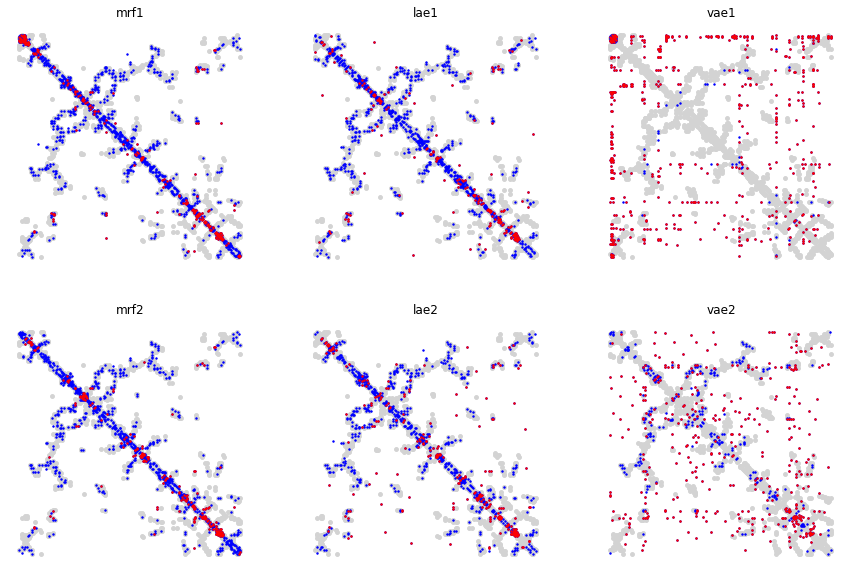

In [22]:
plt.figure(figsize=(15,10))

params = {"cutoffs":[0.01,None], "ss":[15,2], "cc":["lightgray","blue"]}

plt.subplot(2,3,1); plt.title("mrf1"); plt.axis(False)
plot_contact_map([cons, contact_preds["mrf1"]], **params)
plt.subplot(2,3,4); plt.title("mrf2"); plt.axis(False)
plot_contact_map([cons, contact_preds["mrf2"]], **params)

plt.subplot(2,3,2); plt.title("lae1"); plt.axis(False)
plot_contact_map([cons, contact_preds["lae1"]], **params)
plt.subplot(2,3,5); plt.title("lae2"); plt.axis(False)
plot_contact_map([cons, contact_preds["lae2"]], **params)

plt.subplot(2,3,3); plt.title("vae1"); plt.axis(False)
plot_contact_map([cons, contact_preds["vae1"]], **params)
plt.subplot(2,3,6); plt.title("vae2"); plt.axis(False)
plot_contact_map([cons, contact_preds["vae2"]], **params)

plt.show()